100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


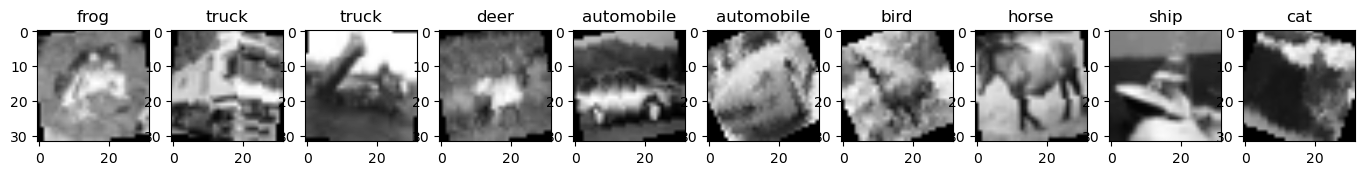

In [7]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import time
import copy


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#apply transforms for data augmentation on CIFAR10 dataset
TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

batch_size = 32

train = torchvision.datasets.CIFAR10(root="./data",
                                        train=True,
                                        transform=TRANSFORMS,
                                        download=True
                                        )

train_dl = DataLoader(train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

classes = train.classes

test = torchvision.datasets.CIFAR10(root="./data", 
                                 train=False, 
                                 transform=TRANSFORMS, 
                                 download=True)

test_dl = DataLoader(test, 
                    batch_size=1, 
                    shuffle=False, 
                    num_workers=0)

dataloaders ={'train': train_dl, 'valid': test_dl, 'test': test_dl}

N_IMAGES = 10

fig, ax = plt.subplots(1, N_IMAGES, figsize=(17,7))

#show 10 images
for i in range(N_IMAGES):
    im, lbl = train[i]

    ax[i].imshow(im[0,:,:], 'gray', interpolation='bilinear')
    ax[i].set_title(f'{classes[lbl]}')


In [8]:

#create our CNN model, which has a Conv2d layer, a batch normalization, a ReLU activation function, and max pooling
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
        self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
        self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
        self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,10),
                                        nn.Softmax())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def ConvModule(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )
        
model = CustomCNN().to(device)

summary(model, input_size=(batch_size, 3,32,32))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 32, 32]          128
│    └─ReLU: 2-3                         [32, 64, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 64, 16, 16]          --
├─Sequential: 1-2                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-5                       [32, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 16, 16]         256
│    └─ReLU: 2-7                         [32, 128, 16, 16]         --
│    └─MaxPool2d: 2-8                    [32, 128, 8, 8]           --
├─Sequential: 1-3                        [32, 256, 4, 4]           --
│    └─Conv2d: 2-9                       [32, 256, 8, 8]           295,168
│

In [9]:

#hyperparameter
learning_rate = 0.001
num_epochs = 35
criterion = nn.CrossEntropyLoss()
#used SGD here, but Adam could be used as the optimizer if not wanting to fine tune parameters
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                #forgot to update best_acc, so the print message should show 0.7805
                best_acc = max(best_acc, epoch_acc)
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss':train_loss_history, 'train_accuracy':train_acc_history,
                    'test_loss':test_loss_history, 'test_accuracy':test_acc_history}
    return model, history_dict

history_dict = {}
model, history_dict = train_model(model, dataloaders, criterion, optimizer, num_epochs)


Epoch 1/35
train Loss: 2.2028, Acc: 0.2665
test Loss: 2.0766, Acc: 0.4089

Epoch 2/35
train Loss: 2.0287, Acc: 0.4436
test Loss: 1.9793, Acc: 0.4889

Epoch 3/35
train Loss: 1.9609, Acc: 0.5059
test Loss: 1.9306, Acc: 0.5380

Epoch 4/35
train Loss: 1.9271, Acc: 0.5392
test Loss: 1.9120, Acc: 0.5527

Epoch 5/35
train Loss: 1.9059, Acc: 0.5575
test Loss: 1.8922, Acc: 0.5697

Epoch 6/35
train Loss: 1.8814, Acc: 0.5825
test Loss: 1.8776, Acc: 0.5830

Epoch 7/35
train Loss: 1.8626, Acc: 0.6011
test Loss: 1.8506, Acc: 0.6098

Epoch 8/35
train Loss: 1.8488, Acc: 0.6144
test Loss: 1.8412, Acc: 0.6236

Epoch 9/35
train Loss: 1.8361, Acc: 0.6260
test Loss: 1.8302, Acc: 0.6335

Epoch 10/35
train Loss: 1.8255, Acc: 0.6372
test Loss: 1.8244, Acc: 0.6375

Epoch 11/35
train Loss: 1.8191, Acc: 0.6435
test Loss: 1.8127, Acc: 0.6496

Epoch 12/35
train Loss: 1.8066, Acc: 0.6564
test Loss: 1.8115, Acc: 0.6518

Epoch 13/35
train Loss: 1.8009, Acc: 0.6617
test Loss: 1.7969, Acc: 0.6651

Epoch 14/35
train Los

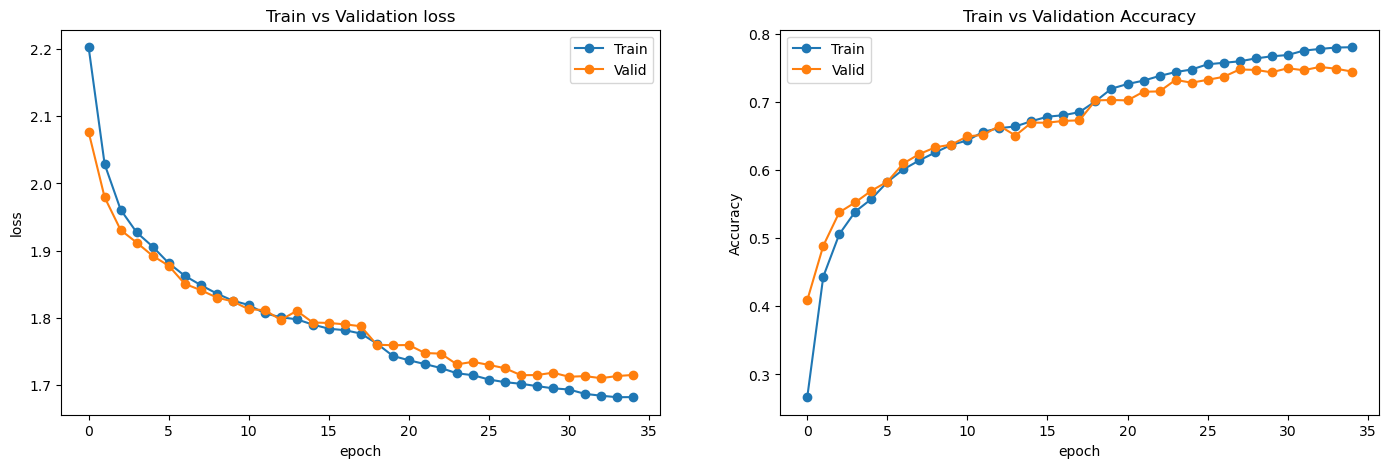

In [10]:

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(history_dict['train_loss'],'-o')
plt.plot(history_dict['test_loss'],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation loss')

plt.subplot(122)
plt.plot(history_dict['train_accuracy'],'-o')
plt.plot(history_dict['test_accuracy'],'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')

 
plt.show()
